#### Quantum Feynman Plots

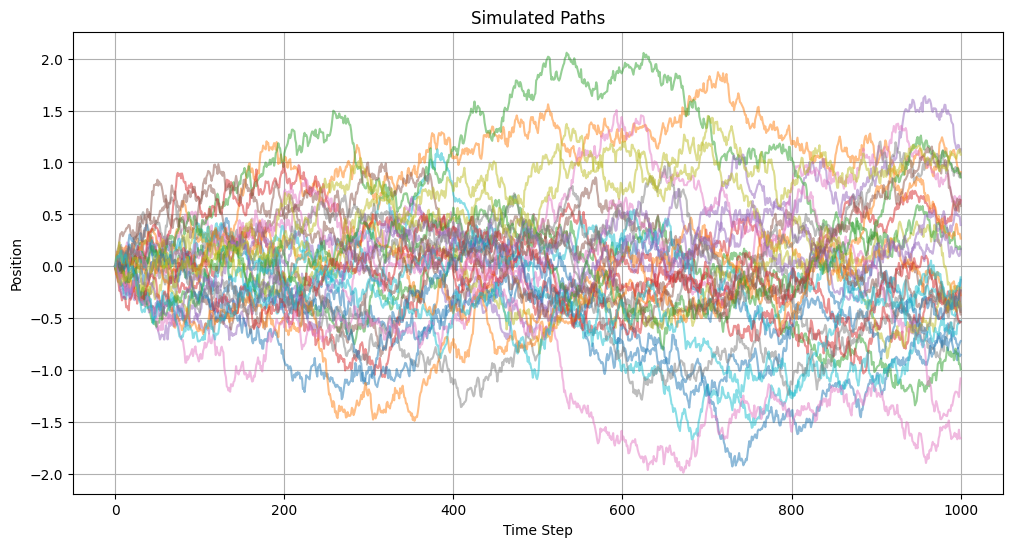

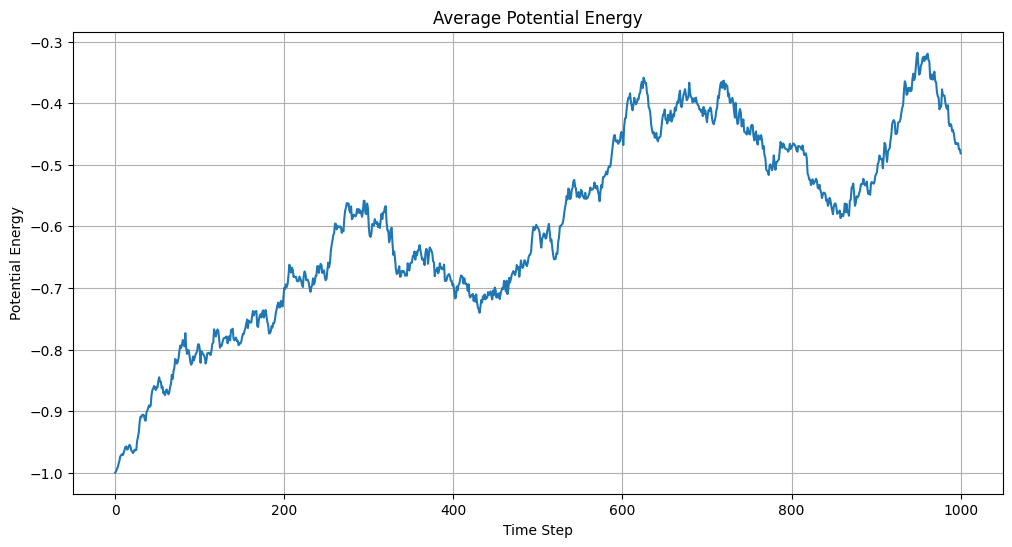

In [5]:
import matplotlib.pyplot as plt
import numpy as np

n_paths = 30
n_steps = 1000
dt = 1.0 / n_steps
mass = 1.0
beta = 1.0

def U(X):
    """Potential energy function: Harmonic oscillator."""
    return 0.5 * mass * X**2 - 1.0 / (np.cosh(X)**2)  # Double-well potential

def V(X):
    """Derivative of the potential energy function."""
    return mass * X + 2.0 * np.tanh(X) / (np.cosh(X)**2)

def simulate_path():
    """Simulate a single path using the Euler-Maruyama method."""
    X = np.zeros(n_steps + 1)
    for i in range(n_steps):
        dW = np.sqrt(dt) * np.random.normal()
        X[i + 1] = X[i] - V(X[i]) * dt + np.sqrt(2.0 / beta) * dW
    return X

def process_paths():
    """Simulate multiple paths and compute the average potential energy."""
    paths = np.array([simulate_path() for _ in range(n_paths)])
    avg_U = np.mean(U(paths), axis=0)
    return paths, avg_U

if __name__ == "__main__":
    paths, avg_U = process_paths()

    # Plot the paths
    plt.figure(figsize=(12, 6))
    for path in paths:
        plt.plot(path, alpha=0.5)
    plt.title("Simulated Paths")
    plt.xlabel("Time Step")
    plt.ylabel("Position")
    plt.grid(True)
    plt.show()

    # Plot the average potential energy
    plt.figure(figsize=(12, 6))
    plt.plot(avg_U)
    plt.title("Average Potential Energy")
    plt.xlabel("Time Step")
    plt.ylabel("Potential Energy")
    plt.grid(True)
    plt.show()


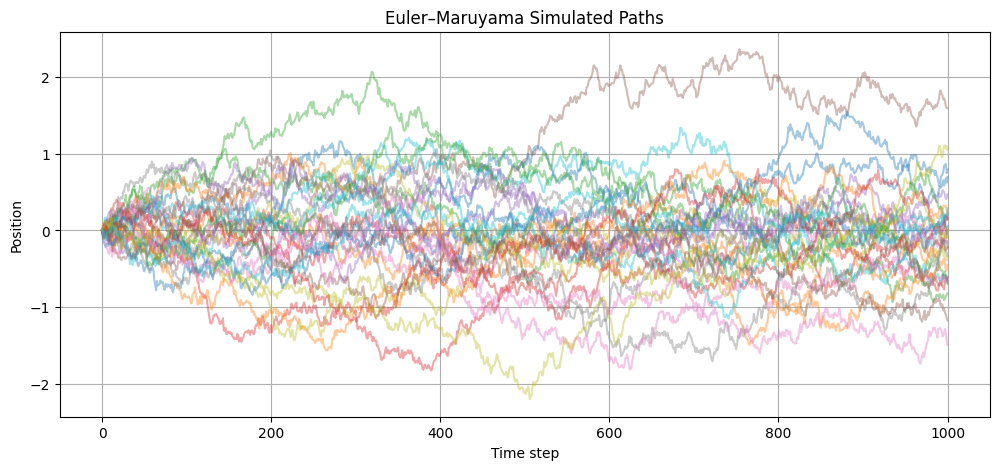

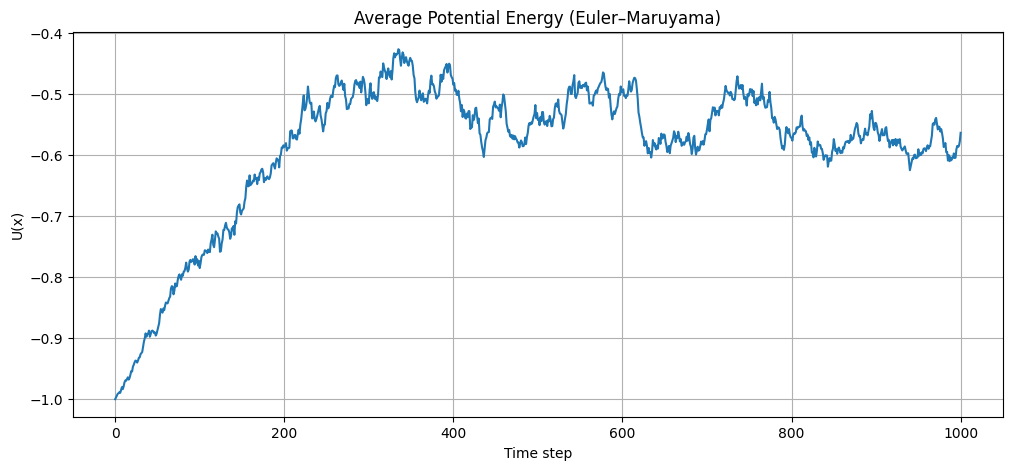

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------- parameters -----------------
n_paths = 30
n_steps = 1000
dt = 1.0 / n_steps
mass = 1.0
beta = 1.0

def U(X):
    """Potential energy function: harmonic + well."""
    return 0.5 * mass * X**2 - 1.0 / (np.cosh(X)**2)

def V(X):
    """Derivative of the potential energy function."""
    return mass * X + 2.0 * np.tanh(X) / (np.cosh(X)**2)


# ----------------- Euler–Maruyama paths -----------------
def simulate_path_em():
    """Simulate a single path using Euler–Maruyama."""
    X = np.zeros(n_steps + 1)
    for i in range(n_steps):
        dW = np.sqrt(dt) * np.random.normal()
        X[i + 1] = X[i] - V(X[i]) * dt + np.sqrt(2.0 / beta) * dW
    return X

def process_paths_em():
    """Simulate multiple EM paths and compute average potential."""
    paths = np.array([simulate_path_em() for _ in range(n_paths)])
    avg_U = np.mean(U(paths), axis=0)
    return paths, avg_U


# ----------------- Euclidean action (vectorized) -----------------
def euclidean_action(path):
    """
    Euclidean action:
        S = ∑_i [ 1/2 m ((x_{i+1}-x_i)/dt)^2 + U(x_i) ] dt
    Vectorized for speed.
    """
    x = np.asarray(path)
    dx = np.diff(x)                     # length n_steps
    kinetic = 0.5 * mass * (dx / dt)**2
    potential = U(x[:-1])               # potential at x_i
    return dt * np.sum(kinetic + potential)


def local_action_slice(path, i):
    """
    Local contribution to the action involving x_i.
    For 1 <= i <= n_steps - 1, the action terms that depend on x_i
    come from slices i-1 and i.

    We return S_{i-1} + S_i (with the dt already included).
    """
    x = path
    S_local = 0.0

    # slice i-1: depends on x_{i-1}, x_i, U(x_{i-1})
    if i - 1 >= 0:
        dx1 = (x[i] - x[i - 1]) / dt
        kinetic1 = 0.5 * mass * dx1**2
        potential1 = U(x[i - 1])
        S_local += dt * (kinetic1 + potential1)

    # slice i: depends on x_i, x_{i+1}, U(x_i)
    if i < len(x) - 1:
        dx2 = (x[i + 1] - x[i]) / dt
        kinetic2 = 0.5 * mass * dx2**2
        potential2 = U(x[i])
        S_local += dt * (kinetic2 + potential2)

    return S_local


# ----------------- Metropolis–Hastings with local updates -----------------
def metropolis_hastings(path, S_current, step_scale=0.5):
    """
    Perform one Metropolis–Hastings sweep over the interior points of the path.
    Uses *local* action updates instead of recomputing the full action.
    """
    # We update path in-place for efficiency
    x = path

    for i in range(1, len(x) - 1):
        old_xi = x[i]

        # Old local contribution around i
        S_old_local = local_action_slice(x, i)

        # Propose new x_i
        proposal = old_xi + np.random.normal(scale=step_scale)
        x[i] = proposal

        # New local contribution
        S_new_local = local_action_slice(x, i)
        delta_S = S_new_local - S_old_local

        # Metropolis acceptance
        if delta_S < 0 or np.random.rand() < np.exp(-delta_S):
            # accept: update global S
            S_current += delta_S
        else:
            # reject: revert x_i
            x[i] = old_xi

    return x, S_current


def simulate_mh_paths(n_paths, n_steps, n_sweeps=300, step_scale=0.5):
    """
    Simulate multiple paths using Metropolis–Hastings.
    Starts from zero paths.
    """
    paths = np.zeros((n_paths, n_steps + 1))
    for p in range(n_paths):
        path = np.zeros(n_steps + 1)
        S_current = euclidean_action(path)

        for _ in range(n_sweeps):
            path, S_current = metropolis_hastings(path, S_current, step_scale=step_scale)

        paths[p] = path
    return paths


# ----------------- main -----------------
if __name__ == "__main__":
    # --- Euler–Maruyama sample ---
    paths_em, avg_U = process_paths_em()

    plt.figure(figsize=(12, 5))
    for path in paths_em:
        plt.plot(path, alpha=0.4)
    plt.title("Euler–Maruyama Simulated Paths")
    plt.xlabel("Time step")
    plt.ylabel("Position")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(avg_U)
    plt.title("Average Potential Energy (Euler–Maruyama)")
    plt.xlabel("Time step")
    plt.ylabel("U(x)")
    plt.grid(True)
    plt.show()

    # --- Metropolis–Hastings sample ---
    # mh_paths = simulate_mh_paths(n_paths, n_steps, n_sweeps=300, step_scale=0.3)

    # plt.figure(figsize=(12, 5))
    # for path in mh_paths:
    #     plt.plot(path, alpha=0.4)
    # plt.title("Metropolis–Hastings Sampled Paths")
    # plt.xlabel("Time step")
    # plt.ylabel("Position")
    # plt.grid(True)
    # plt.show()

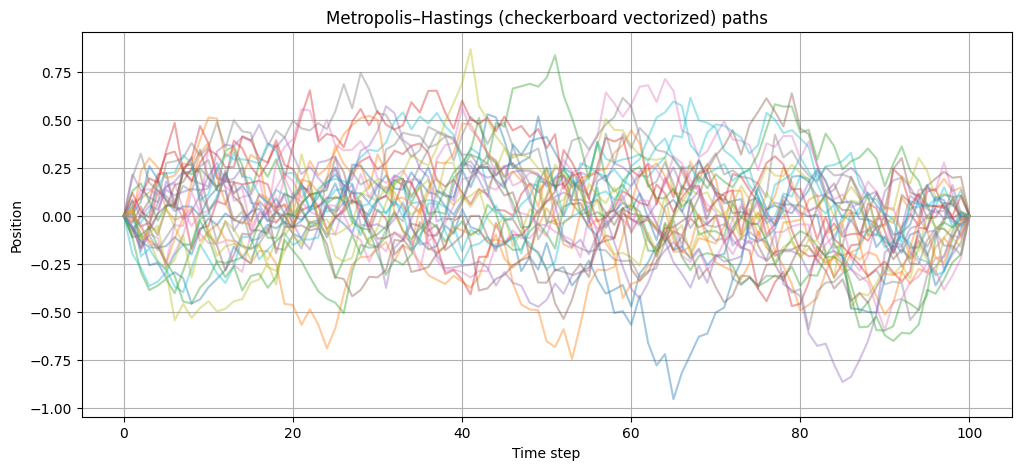

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------- parameters -----------------
n_paths = 30
n_steps = 100
dt = 1.0 / n_steps
mass = 1.0
beta = 1.0

dtinv = 1.0 / dt
kin_c = 0.5 * mass * dtinv  # because dt * 0.5*m*(dx/dt)^2 = 0.5*m*(dx^2)/dt
# potential contribution is dt * U(x)

def U_vec(x):
    """Vectorized potential U(x)."""
    # 0.5*m*x^2 - sech(x)^2  where sech^2 = 1/cosh^2
    c = np.cosh(x)
    return 0.5 * mass * x**2 - 1.0 / (c * c)

def mh_sweep_checkerboard(x, step_scale):
    """
    One MH sweep using checkerboard (even then odd) vectorized updates.
    x: path array of shape (n_steps+1,)
    Updates indices 1..n_steps-1.
    """
    # Helper: update a subset of indices I in one vectorized shot
    def update_indices(I):
        nonlocal x
        if I.size == 0:
            return

        xm = x[I - 1]
        xi = x[I]
        xp = x[I + 1]

        # Old local action terms affected by xi:
        # S_local = dt*[ 0.5*m((xi-xm)/dt)^2 + U(xm) ] + dt*[ 0.5*m((xp-xi)/dt)^2 + U(xi) ]
        #        = 0.5*m*(xi-xm)^2/dt + dt*U(xm) + 0.5*m*(xp-xi)^2/dt + dt*U(xi)
        # Note: dt*U(xm) doesn't change when updating xi, but it cancels in delta; we can omit it.
        # We'll compute only the xi-dependent parts (kinetic both sides + potential at xi).
        old = kin_c * (xi - xm)**2 + kin_c * (xp - xi)**2 + dt * U_vec(xi)

        # Propose
        prop = xi + np.random.normal(scale=step_scale, size=xi.shape)

        new = kin_c * (prop - xm)**2 + kin_c * (xp - prop)**2 + dt * U_vec(prop)

        dS = new - old
        accept = (dS < 0.0) | (np.random.rand(I.size) < np.exp(-dS))

        # Apply accepted proposals
        x[I[accept]] = prop[accept]

    # Interior indices
    idx = np.arange(1, len(x) - 1)

    # Checkerboard split
    even = idx[idx % 2 == 0]
    odd  = idx[idx % 2 == 1]

    update_indices(even)
    update_indices(odd)

    return x


def simulate_mh_paths_fast(n_paths, n_steps, n_sweeps=300, step_scale=0.3, burn_in=0):
    """
    Simulate MH paths with vectorized checkerboard sweeps.
    """
    paths = np.zeros((n_paths, n_steps + 1), dtype=float)

    for p in range(n_paths):
        x = np.zeros(n_steps + 1, dtype=float)

        # burn-in sweeps (optional)
        for _ in range(burn_in):
            mh_sweep_checkerboard(x, step_scale)

        # collect final state after n_sweeps (you could also thin & store multiple samples)
        for _ in range(n_sweeps):
            mh_sweep_checkerboard(x, step_scale)

        paths[p] = x

    return paths


# ----------------- run + plot -----------------
if __name__ == "__main__":
    mh_paths = simulate_mh_paths_fast(
        n_paths=n_paths,
        n_steps=n_steps,
        n_sweeps=300,
        step_scale=0.3,
        burn_in=0
    )

    plt.figure(figsize=(12, 5))
    for path in mh_paths:
        plt.plot(path, alpha=0.4)
    plt.title("Metropolis–Hastings (checkerboard vectorized) paths")
    plt.xlabel("Time step")
    plt.ylabel("Position")
    plt.grid(True)
    plt.show()

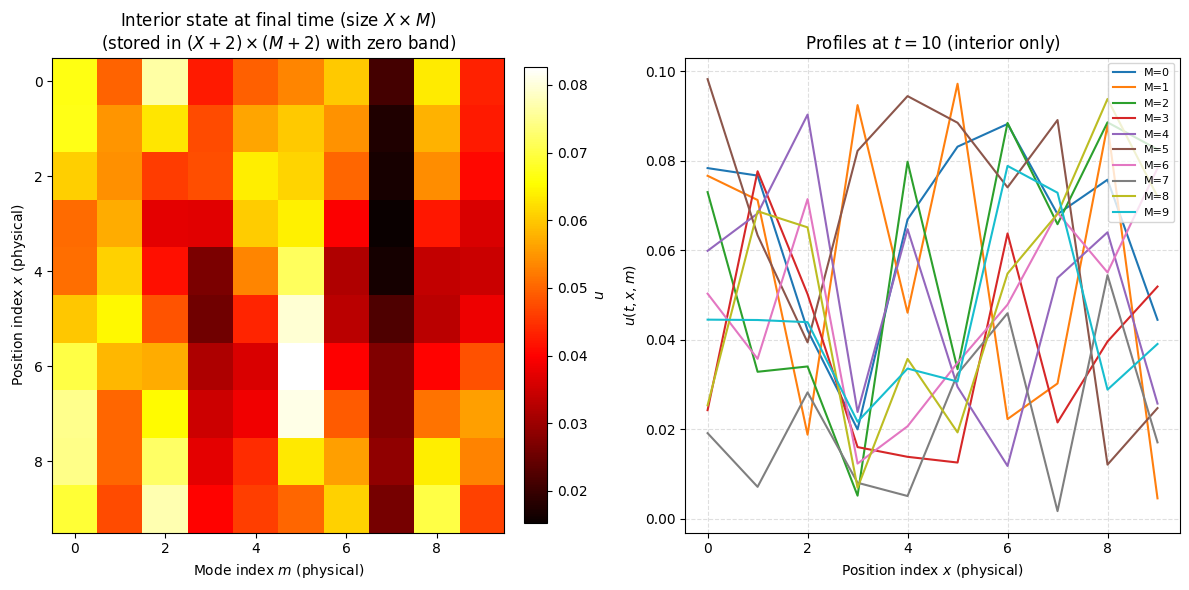

M=0       M=1       M=2       M=3       M=4       M=5       M=6  \
pos                                                                         
0    0.078385  0.076671  0.073021  0.024278  0.059893  0.098273  0.050326   
1    0.076713  0.071255  0.032861  0.077681  0.068240  0.063375  0.035755   
2    0.042132  0.018796  0.034049  0.050212  0.090344  0.039429  0.071461   
3    0.019987  0.092470  0.005168  0.016026  0.023865  0.082241  0.012342   
4    0.066898  0.046065  0.079813  0.013853  0.064739  0.094479  0.020677   
5    0.083176  0.097244  0.033435  0.012574  0.029488  0.088528  0.034883   
6    0.088251  0.022292  0.088494  0.063787  0.011808  0.074077  0.047866   
7    0.068107  0.030247  0.065845  0.021539  0.053850  0.089130  0.068422   
8    0.075792  0.087980  0.088619  0.039623  0.064037  0.012107  0.055072   
9    0.044478  0.004571  0.082576  0.051910  0.025753  0.024740  0.078359   

          M=7       M=8       M=9  
pos                                
0    0.019144  0.025369  0.044513  
1    0.007142  0.068750  0.044433  
2    0.028261  0.065142  0.043953  
3    0.008053  0.006935  0.021700  
4    0.005091  0.035741  0.033582  
5    0.032387  0.019312  0.030678  
6    0.045947  0.054824  0.078878  
7    0.001715  0.068173  0.072880  
8    0.054452  0.093843  0.028870  
9    0.017086  0.072039  0.039074

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# -----------------------------
# Setup
# -----------------------------
T, X, M = 2000, 10, 10          # <-- physical interior is exactly X by M
Xp, Mp = X + 2, M + 2           # <-- padded with a 1-cell zero band on all sides

U0 = np.zeros((T, Xp, Mp), dtype=float)
U0[0, 1:-1, 1:-1] = np.random.rand(X, M) * 0.1  # initialize ONLY interior

dt = 0.01
niu = 0.05
t_f = 10
dx = 1.0  # explicit grid spacing


def enforce_zero_band(U):
    """Hard-enforce the zero band (ghost cells) on all time slices."""
    U[:, 0, :] = 0.0
    U[:, -1, :] = 0.0
    U[:, :, 0] = 0.0
    U[:, :, -1] = 0.0
    return U


def numeric_navier_stokes(U, dt=dt, niu=niu, dx=dx):
    """
    1D Burgers-like per-mode update on the *interior* (size X by M),
    stored inside a padded array of size (X+2) by (M+2) with a zero boundary band.

    - Periodic derivative stencil in x is applied only over the interior x-index (1..X),
      i.e. x=1 wraps to x=X, x=X wraps to x=1.
    - We update ONLY interior indices: x=1..X, m=1..M.
    - Ghost band (x=0,x=X+1,m=0,m=M+1) stays exactly zero.
    """
    U = np.array(U, copy=True, dtype=float)
    T, Xp, Mp = U.shape
    X = Xp - 2
    M = Mp - 2

    U = enforce_zero_band(U)

    # convenience slices for interior
    xs = slice(1, X + 1)   # 1..X inclusive
    ms = slice(1, M + 1)   # 1..M inclusive

    for t in range(T - 1):
        Ut = U[t].copy()  # includes ghost band

        # Extract interior block (X by M)
        Uin = Ut[xs, ms]  # shape (X, M)

        # Periodic x-neighbors on the INTERIOR ONLY
        Uin_xp = np.roll(Uin, -1, axis=0)   # x+1 with wrap within [1..X]
        Uin_xm = np.roll(Uin,  1, axis=0)   # x-1 with wrap within [1..X]

        du_dx = (Uin_xp - Uin_xm) / (2.0 * dx)
        d2u_dx2 = (Uin_xp - 2.0 * Uin + Uin_xm) / (dx**2)

        Uin_next = Uin - (Uin * du_dx) * dt + niu * d2u_dx2 * dt

        # next state: start from current, update only interior, then enforce zeros
        U[t + 1] = Ut
        U[t + 1, xs, ms] = Uin_next
        enforce_zero_band(U)

    return U


def spectral_analysis(U):
    """
    FFT along x over the PHYSICAL interior (size X) for each time and physical mode m.
    Input U: (T, X+2, M+2)
    Output: (T, M, X) in the order (t, m, k)
    """
    T, Xp, Mp = U.shape
    X = Xp - 2
    M = Mp - 2

    xs = slice(1, X + 1)
    ms = slice(1, M + 1)

    specta = np.zeros((T, M, X), dtype=np.complex128)
    for t in range(T):
        for m in range(M):
            specta[t, m] = np.fft.fft(U[t, xs, m + 1])  # m+1 maps physical m=0..M-1 to padded index 1..M
    return specta


# -----------------------------
# Run
# -----------------------------
U_forced = numeric_navier_stokes(U0, dt=dt, niu=niu, dx=dx)

# -----------------------------
# Plot (aligned) — show interior only (X by M), but keep full storage padded
# -----------------------------
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

# final-time interior heatmap: shape (X, M)
U_final_interior = U_forced[-1, 1:-1, 1:-1]
heatmap = ax0.imshow(U_final_interior, cmap="hot", interpolation="nearest", aspect="auto")
ax0.set_title("Interior state at final time (size $X\\times M$)\n(stored in $(X+2)\\times(M+2)$ with zero band)")
ax0.set_xlabel("Mode index $m$ (physical)")
ax0.set_ylabel("Position index $x$ (physical)")
fig.colorbar(heatmap, ax=ax0, fraction=0.046, pad=0.04, label=r"$u$")

# line profiles at time t_f: plot physical x profiles for each physical mode m
lines = ax1.plot(U_forced[t_f, 1:-1, 1:-1])  # shape (X, M) -> plots M curves vs x-index
ax1.set_title(rf"Profiles at $t={t_f}$ (interior only)")
ax1.set_xlabel("Position index $x$ (physical)")
ax1.set_ylabel(r"$u(t,x,m)$")
ax1.legend([f"M={m}" for m in range(M)], loc="upper right", fontsize=8)
ax1.grid(True, ls="--", alpha=0.4)

plt.tight_layout()
plt.show()

# -----------------------------
# Snapshot DataFrame (interior only; exactly X by M)
# -----------------------------
snapshot = U_forced[t_f, 1:-1, 1:-1]  # (X, M)
df_snapshot = pd.DataFrame(snapshot, columns=[f"M={m}" for m in range(M)])
df_snapshot["pos"] = np.arange(X)  # physical x index 0..X-1
df_snapshot.set_index("pos", inplace=True)
display(df_snapshot)

embed_limit ≈ 20.0 MB, target ≈ 2.00 MB
avg bytes/frame ≈ 111.1 KB
keeping 18 / 2000 frames (evenly spaced)
X_spec=10, plotted_len=10, interior_only=False


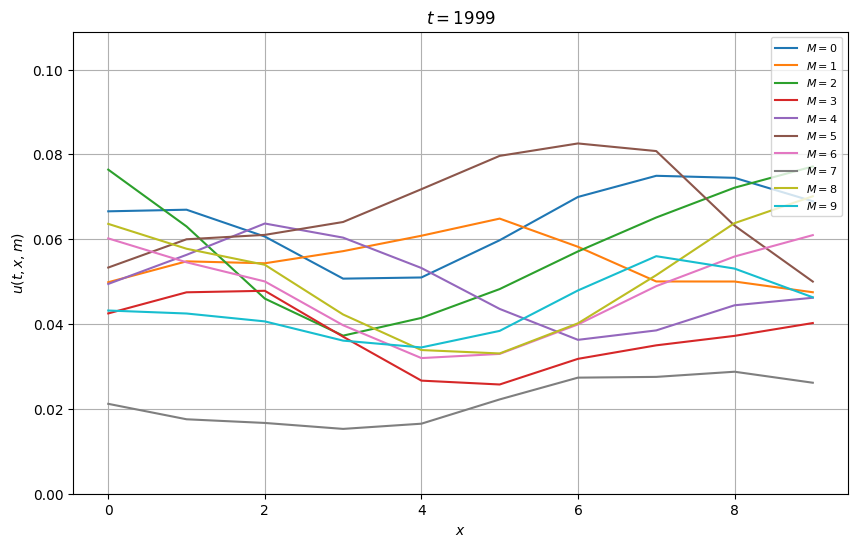

In [9]:
import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ---- REQUIREMENTS ----
# U_forced exists with shape (T, X_plot, M)
# spectral_analysis(U) returns shape (T, M, X_plot)
# ----------------------

# Compute spectra ONCE from the same U_forced you animate
spectra = spectral_analysis(U_forced)  # (T, M, X_spec)

T = spectra.shape[0]
M = spectra.shape[1]
X_spec = spectra.shape[2]              # <-- THE only X we trust for plotting

def build_budgeted_animation(max_fraction=0.1, interval=120, probe_frames=8, interior_only=False):
    """
    - max_fraction: fraction of matplotlib animation.embed_limit (MB) to use (default 0.1)
    - interior_only: if True, plot indices 1..X_spec-2 (excludes padded zero band)
    """

    # Decide which x-indices to plot
    if interior_only:
        idx = slice(1, X_spec - 1)     # length = X_spec - 2
    else:
        idx = slice(None)              # length = X_spec

    X_plot = np.arange(X_spec)[idx]    # x coordinates (consistent)
    plot_len = X_plot.shape[0]

    # Byte budget
    embed_limit_mb = float(plt.rcParams.get("animation.embed_limit", 20.0))
    target_bytes = float(max_fraction) * embed_limit_mb * 1024 * 1024

    fig, ax = plt.subplots(figsize=(10, 6))

    # Pre-create artists with correct length
    lines = []
    for m in range(M):
        (ln,) = ax.plot(X_plot, np.zeros(plot_len, dtype=float), lw=1.5, label=rf"$M={m}$")
        lines.append(ln)

    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$u(t,x,m)$")

    # Set y-limits based on the SAME slice we will plot
    U_slice = U_forced[:, idx, :] if U_forced.shape[1] == X_spec else None
    if U_slice is not None:
        ymin = np.nanmin(U_slice) * 1.1
        ymax = np.nanmax(U_slice) * 1.1
    else:
        # fallback: just use spectra-derived reconstruction at a few frames
        ymin, ymax = -1.0, 1.0
    ax.set_ylim(np.min(U_forced) * 1.1, np.max(U_forced) * 1.1)

    ax.grid(True)
    ax.legend(loc="upper right", fontsize=8)
    title = ax.set_title(r"$t=0$")

    def set_frame(t):
        """Update all lines to frame t, guaranteeing exact length."""
        t = int(t) % T
        for m, ln in enumerate(lines):
            # n=X_spec forces exact-length IFFT even if something weird happens
            y_full = np.fft.ifft(spectra[t, m], n=X_spec).real
            ln.set_ydata(y_full[idx])  # slice to match x
        title.set_text(rf"$t={t}$")
        return [title, *lines]

    # ---- estimate avg bytes/frame by rendering a few frames to PNG ----
    def estimate_bytes_per_frame(frames_probe):
        buf = io.BytesIO()
        sizes = []
        for t in frames_probe:
            set_frame(t)
            fig.canvas.draw()
            buf.seek(0); buf.truncate(0)
            fig.canvas.print_png(buf)
            sizes.append(buf.tell())
        return float(np.mean(sizes)) if sizes else 1.0

    probe_frames = int(max(1, min(probe_frames, T)))
    frames_probe = np.linspace(0, T - 1, probe_frames, dtype=int)
    avg_bpf = estimate_bytes_per_frame(frames_probe)

    max_frames = int(max(2, min(T, np.floor(target_bytes / max(avg_bpf, 1.0)))))
    frames = np.linspace(0, T - 1, max_frames, dtype=int).tolist()

    def init():
        return set_frame(frames[0])

    def update(t):
        return set_frame(t)

    ani = FuncAnimation(
        fig,
        update,
        frames=frames,
        init_func=init,
        interval=interval,
        blit=True
    )

    print(f"embed_limit ≈ {embed_limit_mb:.1f} MB, target ≈ {target_bytes/1024/1024:.2f} MB")
    print(f"avg bytes/frame ≈ {avg_bpf/1024:.1f} KB")
    print(f"keeping {len(frames)} / {T} frames (evenly spaced)")
    print(f"X_spec={X_spec}, plotted_len={plot_len}, interior_only={interior_only}")

    return ani

# ---- Use ONE of these (don’t mix them) ----
ani = build_budgeted_animation(max_fraction=0.1, interval=120, probe_frames=8, interior_only=False)
# ani = build_budgeted_animation(max_fraction=0.1, interval=120, probe_frames=8, interior_only=True)

HTML(ani.to_jshtml())

In [10]:
import numpy as np
import plotly.graph_objects as go
import json

def plotly_budgeted_animation(U_forced, max_fraction=0.1, interior_only=False, frame_duration=150):
    """
    Plotly animation with:
      - consistent x/y lengths (single source of truth)
      - optional interior-only plotting (exclude zero band)
      - frame subsampling to keep payload small:
          keep ~max_fraction of the full (all-frames) JSON payload
    """
    U_forced = np.asarray(U_forced)
    T, X_true, M = U_forced.shape  # <-- single source of truth

    # Pick slice: full or interior (exclude padded zero band)
    if interior_only:
        idx = slice(1, X_true - 1)
    else:
        idx = slice(None)

    xgrid = np.arange(X_true, dtype=float)[idx]
    plot_len = xgrid.shape[0]

    # ---- helper: approximate payload size of one frame in JSON bytes ----
    def frame_payload_bytes(t):
        # build a minimal "data" representation for this frame
        data = [{"x": xgrid.tolist(), "y": U_forced[t, idx, m].tolist()} for m in range(M)]
        return len(json.dumps(data).encode("utf-8"))

    # Estimate typical frame size using a few probes
    probe = min(8, T)
    probe_ts = np.linspace(0, T - 1, probe, dtype=int)
    avg_bpf = float(np.mean([frame_payload_bytes(t) for t in probe_ts]))

    # Estimate full payload if we used all T frames (rough)
    full_est_bytes = avg_bpf * T
    target_bytes = max_fraction * full_est_bytes

    # Choose how many frames to keep
    max_frames = int(max(2, min(T, np.floor(target_bytes / max(avg_bpf, 1.0)))))
    keep_ts = np.linspace(0, T - 1, max_frames, dtype=int).tolist()

    print(f"T={T}, X_true={X_true}, M={M}, plotted_len={plot_len}, interior_only={interior_only}")
    print(f"avg bytes/frame ≈ {avg_bpf/1024:.1f} KB, full est ≈ {full_est_bytes/1024/1024:.2f} MB")
    print(f"keeping {len(keep_ts)} / {T} frames (~{100*len(keep_ts)/T:.1f}%)")

    # ---- initial traces ----
    traces0 = [
        go.Scatter(
            x=xgrid,
            y=U_forced[keep_ts[0], idx, m],
            mode="lines",
            name=f"M={m}",
        )
        for m in range(M)
    ]

    # ---- frames ----
    frames = []
    for t in keep_ts:
        fr_data = [
            go.Scatter(x=xgrid, y=U_forced[t, idx, m], mode="lines", name=f"M={m}")
            for m in range(M)
        ]
        frames.append(go.Frame(data=fr_data, name=str(t)))

    # ---- slider steps (only kept frames) ----
    slider_steps = [
        {
            "method": "animate",
            "args": [[str(t)], {"mode": "immediate", "frame": {"duration": 0, "redraw": True}}],
            "label": str(t),
        }
        for t in keep_ts
    ]

    fig = go.Figure(
        data=traces0,
        frames=frames,
        layout=go.Layout(
            title="Temperature Profiles",
            xaxis_title="x",
            yaxis_title="u(t,x,m)",
            updatemenus=[{
                "type": "buttons",
                "buttons": [
                    {
                        "label": "Play",
                        "method": "animate",
                        "args": [None, {"frame": {"duration": frame_duration, "redraw": True}, "fromcurrent": True}],
                    },
                    {
                        "label": "Pause",
                        "method": "animate",
                        "args": [[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}],
                    },
                ],
            }],
            sliders=[{
                "steps": slider_steps,
                "currentvalue": {"prefix": "t="},
            }],
        ),
    )

    return fig

# ---- Usage ----
fig = plotly_budgeted_animation(U_forced, max_fraction=0.1, interior_only=False, frame_duration=150)
fig.show()

# If you have a padded zero band and want to exclude it:

T=2000, X_true=12, M=12, plotted_len=12, interior_only=False
avg bytes/frame ≈ 3.2 KB, full est ≈ 6.25 MB
keeping 200 / 2000 frames (~10.0%)


In [11]:
# after you create ani
ani.save("u_profiles.mp4", writer="ffmpeg", fps=10, dpi=150)
ani.save("u_profiles.gif", writer="pillow", fps=10)

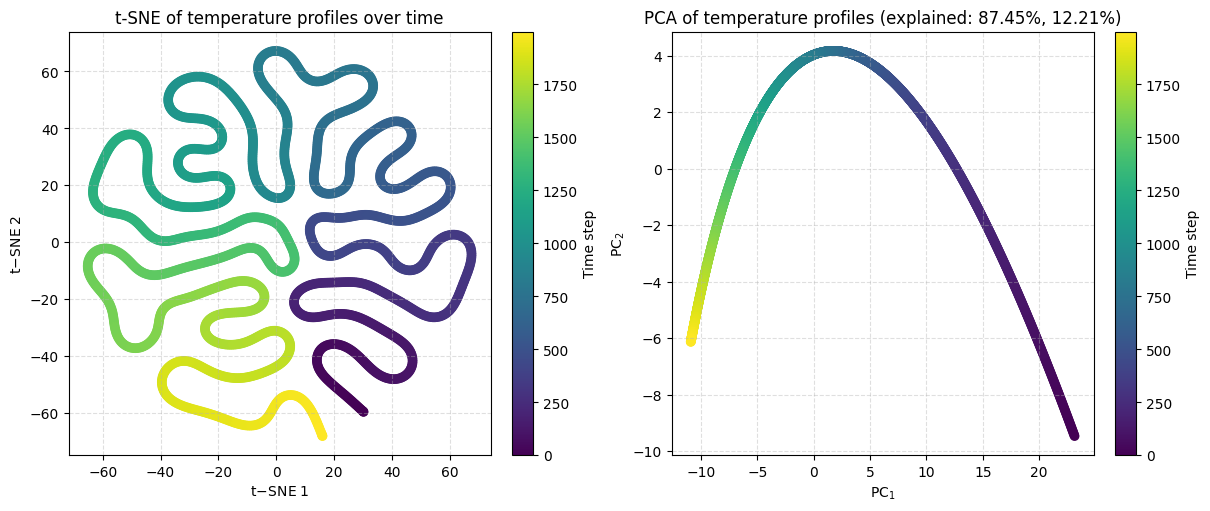

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Flatten time snapshots: shape (T, X*M)
T, X, M = U_forced.shape
U_flat = U_forced.reshape(T, X * M).astype(float)

# Standardize features (recommended for PCA + t-SNE)
mu = U_flat.mean(axis=0, keepdims=True)
sigma = U_flat.std(axis=0, keepdims=True) + 1e-10
U_std = (U_flat - mu) / sigma

# --- PCA (proper) ---
pca = PCA(n_components=2, random_state=0)
U_pca2 = pca.fit_transform(U_std)

# --- t-SNE (init='pca' uses PCA initialization internally) ---
tsne = TSNE(
    n_components=2,
    perplexity=5,
    learning_rate=10,
    max_iter=1000,      # newer sklearn uses max_iter; older used n_iter
    init="pca",
    random_state=0
)
U_tsne = tsne.fit_transform(U_std)

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

t_color = np.arange(T)

sc1 = axes[0].scatter(U_tsne[:, 0], U_tsne[:, 1], c=t_color)
cbar1 = fig.colorbar(sc1, ax=axes[0])
cbar1.set_label("Time step")
axes[0].set_title("t-SNE of temperature profiles over time")
axes[0].set_xlabel(r"$\mathrm{t\!-\!SNE}\;1$")
axes[0].set_ylabel(r"$\mathrm{t\!-\!SNE}\;2$")
axes[0].grid(True, ls="--", alpha=0.4)

sc2 = axes[1].scatter(U_pca2[:, 0], U_pca2[:, 1], c=t_color)
cbar2 = fig.colorbar(sc2, ax=axes[1])
cbar2.set_label("Time step")
axes[1].set_title(
    rf"PCA of temperature profiles (explained: "
    rf"{pca.explained_variance_ratio_[0]:.2%}, {pca.explained_variance_ratio_[1]:.2%})"
)
axes[1].set_xlabel(r"$\mathrm{PC}_1$")
axes[1].set_ylabel(r"$\mathrm{PC}_2$")
axes[1].grid(True, ls="--", alpha=0.4)

plt.show()

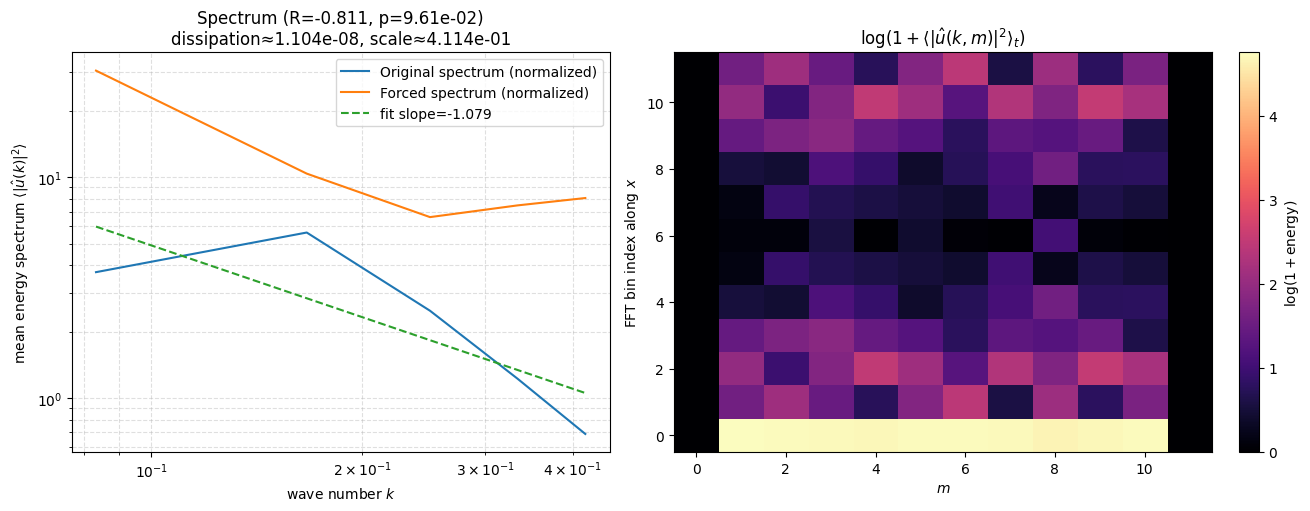

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# -----------------------------
# Helpers: normalize + finite guards
# -----------------------------
def normalize_rms_per_mode(U, eps=1e-12):
    """
    Normalize U[t, :, m] so each (t,m) slice has RMS ~ 1.
    Shape: (T, X, M) -> (T, X, M)
    """
    U = np.asarray(U, dtype=float)
    rms = np.sqrt(np.mean(U**2, axis=1, keepdims=True) + eps)  # (T,1,M)
    return U / rms

def clip_and_finite(U, clip=10.0):
    """
    Replace non-finite with 0 and clip amplitudes to [-clip, clip].
    """
    U = np.nan_to_num(U, nan=0.0, posinf=0.0, neginf=0.0)
    if clip is not None:
        U = np.clip(U, -clip, clip)
    return U

# -----------------------------
# Assumes: U_forced shape (T, X, M), dt, niu defined
# -----------------------------
T, X, M = U_forced.shape
omega = 2 * np.pi / T
xgrid = np.arange(X, dtype=float)
eps = 1e-300

# -----------------------------
# 0) Normalize FIRST to prevent overflow in FFT energy
# -----------------------------
U_norm = clip_and_finite(normalize_rms_per_mode(U_forced), clip=10.0)

# ---------- Original spectrum ----------
F_orig = np.fft.fft(U_norm, axis=1)                   # (T, X, M)
E_orig = (F_orig.real**2 + F_orig.imag**2)            # same as |F|^2, but stable
mean_spectrum = E_orig.mean(axis=(0, 2))              # (X,)

k = np.fft.fftfreq(X, d=1.0)
k_pos = k[: X // 2]
spec_pos = mean_spectrum[: X // 2]

valid = k_pos > 0
log_k = np.log(k_pos[valid])
log_E = np.log(spec_pos[valid] + eps)

slope, intercept, r_value, p_value, std_err = stats.linregress(log_k, log_E)

# ---------- Dissipation proxy ----------
E_t = E_orig.sum(axis=(1, 2))                         # (T,)
dE_dt = np.gradient(E_t, dt)
dissipation_rate = (-dE_dt).mean()

logk = np.log(k_pos[valid])
logs = np.log(spec_pos[valid] + eps)
local_slope = np.gradient(logs, logk)
dissipation_scale = -local_slope[-1] / (2 * np.pi)

# -----------------------------
# Forced simulation (normalized + clipped each step to prevent blow-up)
# -----------------------------
V_f = np.zeros_like(U_norm)
V_f[0] = U_norm[0]

forcing_x = np.sin(2 * np.pi * xgrid / X)

for t in range(T - 1):
    forcing_t = np.cos(omega * t)
    f_xt = forcing_x * forcing_t                      # (X,)

    # Take current slice
    Ut = V_f[t].copy()                                # (X,M)
    Ut = clip_and_finite(Ut, clip=10.0)

    # Compute derivatives along x for all modes at once (vectorized over m)
    # central diff interior; keep boundaries zero-derivative here
    du_dx = np.zeros_like(Ut)
    d2u_dx2 = np.zeros_like(Ut)

    du_dx[1:-1, :] = (Ut[2:, :] - Ut[:-2, :]) / 2.0
    d2u_dx2[1:-1, :] = (Ut[2:, :] - 2.0 * Ut[1:-1, :] + Ut[:-2, :])

    # Nonlinear update (broadcast f_xt over modes)
    # IMPORTANT: multiply can overflow if Ut is huge; we already normalized+clipped
    U_next = Ut - (Ut * du_dx) * dt + niu * d2u_dx2 * dt + (f_xt[:, None] * dt)

    # Guard, then normalize next step (keeps dynamics bounded)
    U_next = clip_and_finite(U_next, clip=10.0)

    # Normalize per-mode RMS for this next time slice (t+1)
    # shape (X,M) -> (X,M)
    rms_next = np.sqrt(np.mean(U_next**2, axis=0, keepdims=True) + 1e-12)  # (1,M)
    U_next = U_next / rms_next

    V_f[t + 1] = U_next

# Forced spectrum
F_forced = np.fft.fft(V_f, axis=1)
E_forced = (F_forced.real**2 + F_forced.imag**2)
mean_spectrum_f = E_forced.mean(axis=(0, 2))
spec_f_pos = mean_spectrum_f[: X // 2]

# Node-energy map: average over time only => (X, M)
node_energy_map = E_orig.mean(axis=0)

# -----------------------------
# Plot (separate axes; aligned; no mixing loglog+imshow on same axis)
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)

# Left: loglog spectra
ax = axes[0]
ax.loglog(k_pos[valid], spec_pos[valid], label="Original spectrum (normalized)")
ax.loglog(k_pos[valid], spec_f_pos[valid], label="Forced spectrum (normalized)")

kline = k_pos[valid]
ax.loglog(kline, np.exp(intercept) * (kline ** slope), ls="--",
          label=rf"fit slope={slope:.3f}")

ax.set_xlabel(r"wave number $k$")
ax.set_ylabel(r"mean energy spectrum $\langle | \hat{u}(k) |^2 \rangle$")
ax.set_title(
    rf"Spectrum (R={r_value:.3f}, p={p_value:.2e})" "\n"
    rf"dissipation≈{dissipation_rate:.3e}, scale≈{dissipation_scale:.3e}"
)
ax.grid(True, which="both", ls="--", alpha=0.4)
ax.legend()

# Right: heatmap across x and m
ax = axes[1]
im = ax.imshow(
    np.log1p(node_energy_map),  # (X,M)
    aspect="auto",
    cmap="magma",
    origin="lower"
)
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"FFT bin index along $x$")
ax.set_title(r"$\log(1 + \langle |\hat{u}(k,m)|^2 \rangle_t)$")
fig.colorbar(im, ax=ax, label=r"$\log(1+\mathrm{energy})$")

plt.show()


#### Burgers Inviscid Navier-Stokes Equations
We consider the 1D Burgers equation as a simplified model for fluid dynamics:
$$\frac{\partial u}{\partial t} = \underbrace{-u \nabla u}_{
\text{Nonlinear Advection: } -u \cdot \partial_{x} u
} + \underbrace{\nu \Delta u}_{
\text{Viscous Diffusion: } \nu \cdot \partial_{xx} u
} + f(t, x)$$
where $u(t, x)$ is the velocity field, $\nu$ is the viscosity, and $f(t, x)$ is an external forcing term. In the inviscid limit ($\nu \to 0$), this reduces to:
$$\frac{\partial u}{\partial t} + u \nabla u = f(t, x), \quad \Delta = \nabla^2 = \nabla \cdot \nabla$$
We consider the periodic sinusodial locomotion as source: $f(t, x) = \sin(2 \pi x) \cdot \cos(\omega t)$ where $\omega = \frac{2 \pi}{T}$ given the period $T$

We will solve this equation using the pseudo-spectral method with the following steps:
1. **Fourier Transform**: Transform the velocity field $u(t, x)$ to Fourier space using the Fast Fourier Transform (FFT).
Over time, only the positive-frequency are kept: keeping half of the nodes over the energy map $U(\cdot, \lfloor\frac{X}{2}\rfloor, \cdot)$
2. **Nonlinear Term Calculation**: Compute the nonlinear term $u \nabla u
$ in physical space and then transform it back to Fourier space.
3. **Time Integration**: Use a time-stepping scheme (e.g., Runge
-Kutta) to advance the solution in time.

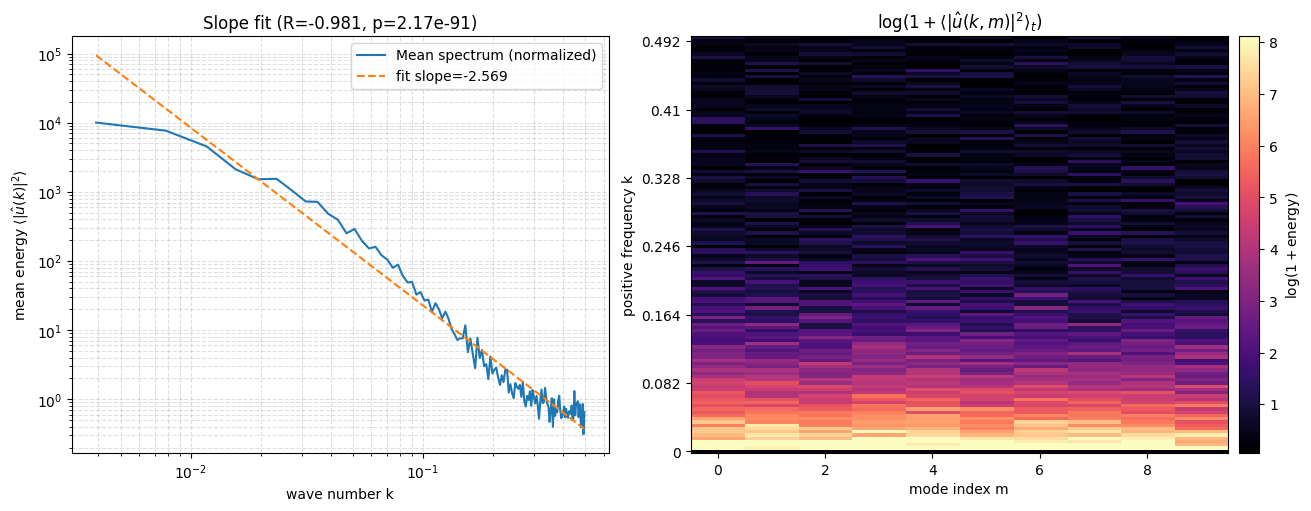

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# ---------- helpers ----------
def normalize_rms_per_mode(U, eps=1e-12):
    U = np.asarray(U, dtype=float)
    rms = np.sqrt(np.mean(U**2, axis=1, keepdims=True) + eps)  # (T,1,M)
    return U / rms

def clip_and_finite(U, clip=10.0):
    U = np.nan_to_num(U, nan=0.0, posinf=0.0, neginf=0.0)
    if clip is not None:
        U = np.clip(U, -clip, clip)
    return U

# ---------- inputs ----------
# assumes: U_forced exists, shape (T, X, M)
T, X, M = U_forced.shape
eps = 1e-300

# ---------- normalize first (prevents overflow in |FFT|^2) ----------
U_norm = clip_and_finite(normalize_rms_per_mode(U_forced), clip=10.0)

# ---------- FFT energy ----------
F = np.fft.fft(U_norm, axis=1)                  # (T, X, M)
E = (F.real**2 + F.imag**2)                     # (T, X, M) = |F|^2

# mean spectrum over time+mode => (X,)
mean_spectrum = E.mean(axis=(0, 2))

k = np.fft.fftfreq(X, d=1.0)
k_pos = k[: X // 2]
spec_pos = mean_spectrum[: X // 2]

# slope fit on k>0
valid = k_pos > 0
log_k = np.log(k_pos[valid])
log_E = np.log(spec_pos[valid] + eps)
slope, intercept, r_value, p_value, std_err = stats.linregress(log_k, log_E)

# node-energy map: average over time, keep only positive-frequency bins
node_energy_map = E.mean(axis=0)                # (X, M)
node_energy_map_pos = node_energy_map[: X // 2, :]   # (X//2, M)
heat = np.log1p(node_energy_map_pos)

vmin, vmax = np.percentile(heat, [2, 98])

# ---------- PLOT (creates its own figure + axes, so it WILL show) ----------
fig, axes = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)

# Left: spectrum + fit
axL = axes[0]
axL.loglog(k_pos[valid], spec_pos[valid], label="Mean spectrum (normalized)")
kline = k_pos[valid]
axL.loglog(kline, np.exp(intercept) * (kline ** slope), "--", label=f"fit slope={slope:.3f}")
axL.set_xlabel("wave number k")
axL.set_ylabel(r"mean energy $\langle|\hat u(k)|^2\rangle$")
axL.set_title(f"Slope fit (R={r_value:.3f}, p={p_value:.2e})")
axL.grid(True, which="both", ls="--", alpha=0.4)
axL.legend(loc="best")

# Right: positive-frequency heatmap (y-axis matches k_pos bins)
axR = axes[1]
im = axR.imshow(
    heat,
    aspect="auto",
    cmap="magma",
    origin="lower",
    extent=[-0.5, M - 0.5, -0.5, (X // 2) - 0.5],
    vmin=vmin,
    vmax=vmax,
)
axR.set_xlabel("mode index m")
axR.set_title(r"$\log(1+\langle|\hat u(k,m)|^2\rangle_t)$")

# y-ticks labeled by actual k_pos values
step = max(1, (X // 2) // 6)
yt = np.arange(0, X // 2, step)
axR.set_yticks(yt)
axR.set_yticklabels([f"{k_pos[i]:.3g}" for i in yt])
axR.set_ylabel("positive frequency k")

cbar = fig.colorbar(im, ax=axR, pad=0.02)
cbar.set_label(r"$\log(1+\mathrm{energy})$")

plt.show()

OK. finite: True | dt range: 0.0004219763357827124 to 0.0007485708367944506
embed_limit ≈ 20.0 MB, target ≈ 2.00 MB
avg bytes/frame ≈ 189.8 KB
keeping 10 / 400 frames (evenly spaced) (~2.5%)


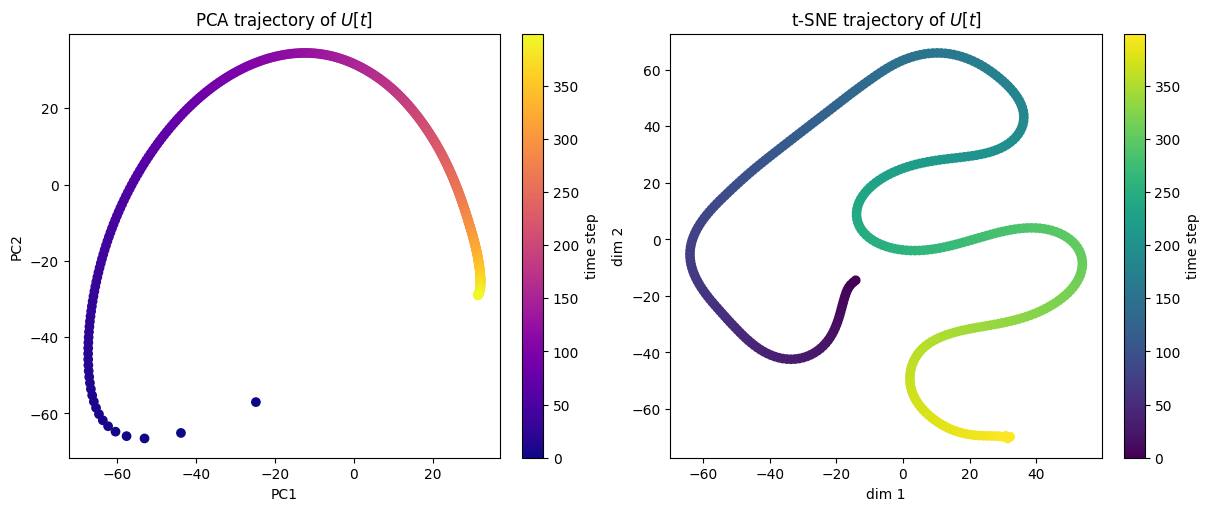

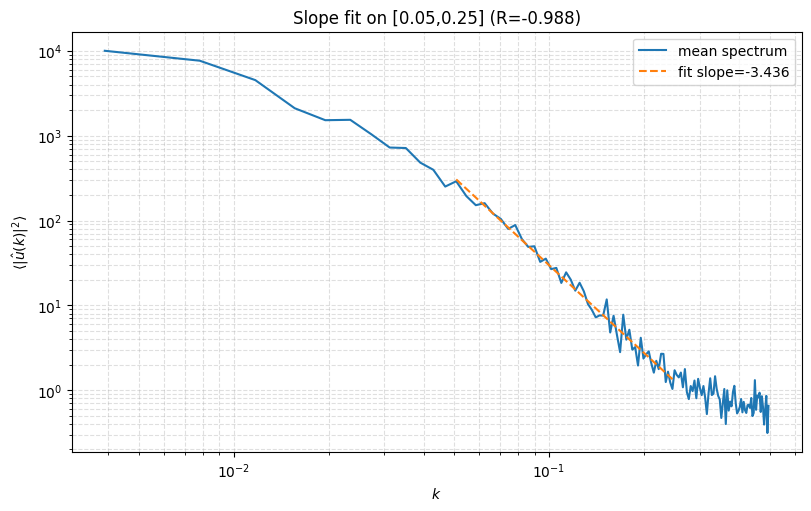

Slope fit: -3.4357563685484145


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# -----------------------------
# 0) Utilities
# -----------------------------
def zscore_features(tensor_2d, eps=1e-12):
    """Z-score normalize features (columns)."""
    mu = tensor_2d.mean(axis=0, keepdims=True)
    sd = tensor_2d.std(axis=0, keepdims=True) + eps
    return (tensor_2d - mu) / sd

def spectral_analysis(U):
    """
    U: (T, X, M)
    returns spectra: (T, M, X)
    """
    T, X, M = U.shape
    out = np.zeros((T, M, X), dtype=np.complex128)
    for t in range(T):
        out[t] = np.fft.fft(U[t].T, axis=1)  # (M, X)
    return out

def pick_evenly_spaced_frames(T, keep):
    keep = int(max(2, min(T, keep)))
    return np.unique(np.linspace(0, T - 1, keep).round().astype(int))

def estimate_bytes_per_frame(fig, update_fn, probe_frames, dpi=90):
    """
    Estimate rendered PNG bytes per frame (proxy for JSHTML size).
    Uses fig.savefig to BytesIO to avoid JSHTML building during estimation.
    """
    import io
    buf = io.BytesIO()
    sizes = []
    for fr in probe_frames:
        update_fn(int(fr))
        buf.seek(0); buf.truncate(0)
        fig.canvas.draw()
        fig.savefig(buf, format="png", dpi=dpi)
        sizes.append(buf.tell())
    return float(np.mean(sizes)) if sizes else 120_000.0


# -----------------------------
# 1) Stable forced 1D Burgers (multi-channel M)
# -----------------------------
def forcing_profile(x):
    return np.sin(2*np.pi*x) + 0.5*np.sin(4*np.pi*x)

def step_burgers_rusanov(u, fx, dx, nu, dt):
    """
    Conservative form:
      u_t + (1/2 u^2)_x = nu u_xx + f(x)
    periodic boundaries (via roll)
    """
    f = 0.5 * u*u
    uR = np.roll(u, -1)
    fR = np.roll(f, -1)
    a = np.maximum(np.abs(u), np.abs(uR))

    F_iphalf = 0.5*(f + fR) - 0.5*a*(uR - u)
    F_imhalf = np.roll(F_iphalf, 1)
    adv = -(F_iphalf - F_imhalf) / dx

    uxx = (np.roll(u, -1) - 2*u + np.roll(u, 1)) / (dx*dx)
    diff = nu * uxx

    return u + dt*(adv + diff + fx)

def simulate_forced_burgers_tensor(
    T=400, X=256, M=10,
    nu=5e-3,
    dt0=2e-3,
    cfl=0.4,
    forcing_amp=0.5,
    normalize_first=True,
    normalize_each_step=True,
    clip_value=None,
    seed=0
):
    rng = np.random.default_rng(seed)
    x = np.linspace(0, 1, X, endpoint=False)
    dx = x[1] - x[0]
    fx = forcing_amp * forcing_profile(x)

    U = np.zeros((T, X, M), dtype=float)
    U[0] = 0.1 * rng.standard_normal((X, M))

    # normalize FIRST (your request)
    if normalize_first:
        mu0 = U[0].mean(axis=0, keepdims=True)              # (1, M)
        sd0 = U[0].std(axis=0, keepdims=True) + 1e-12
        U[0] = (U[0] - mu0) / sd0

    dt_hist = np.zeros(T, dtype=float)

    for t in range(1, T):
        umax = np.max(np.abs(U[t-1]))
        dt_adv = cfl * dx / (umax + 1e-12)
        dt_diff = 0.5 * dx*dx / (nu + 1e-12)
        dt = min(dt0, dt_adv, dt_diff)
        dt_hist[t] = dt

        for m in range(M):
            u = U[t-1, :, m]
            u_new = step_burgers_rusanov(u, fx, dx, nu, dt)
            if clip_value is not None:
                u_new = np.clip(u_new, -clip_value, clip_value)
            U[t, :, m] = u_new

        if normalize_each_step:
            mu = U[t].mean(axis=0, keepdims=True)
            sd = U[t].std(axis=0, keepdims=True) + 1e-12
            U[t] = (U[t] - mu) / sd

        if not np.isfinite(U[t]).all():
            raise FloatingPointError(
                f"Non-finite values at t={t}. Try smaller dt0, larger nu, "
                f"enable clip_value, or keep normalization on."
            )

    return U, x, dt_hist


# -----------------------------
# 2) Run simulation
# -----------------------------
T, X, M = 400, 256, 10
nu = 5e-3
dt0 = 2e-3

U_forced, xgrid, dt_hist = simulate_forced_burgers_tensor(
    T=T, X=X, M=M,
    nu=nu, dt0=dt0,
    cfl=0.4,
    forcing_amp=0.5,
    normalize_first=True,
    normalize_each_step=True,
    clip_value=None,
    seed=0
)

dt_nonzero = dt_hist[dt_hist > 0]
print("OK. finite:", np.isfinite(U_forced).all(),
      "| dt range:", (dt_nonzero.min() if len(dt_nonzero) else None), "to", dt_hist.max())


# -----------------------------
# 3) Animation with frame+byte budget (default 10%)
# -----------------------------
# defaults you asked for
frame_frac = 0.10            # keep <= 10% frames
embed_limit_mb = 20.0        # typical matplotlib embed limit
target_embed_frac = 0.10     # target <= 10% of embed_limit (≈2MB)
probe_n = 10                 # frames to probe for bytes/frame

fig = plt.figure(figsize=(12, 5))
axL = fig.add_subplot(1, 2, 1)
axR = fig.add_subplot(1, 2, 2)

heatmap = axL.imshow(U_forced[0], aspect="auto", cmap="viridis", origin="lower")
axL.set_title("State $U[t, x, m]$")
axL.set_xlabel("mode $m$")
axL.set_ylabel("position $x$")

lines = []
for m in range(M):
    (ln,) = axR.plot(xgrid, U_forced[0, :, m], lw=1.2, label=f"m={m}")
    lines.append(ln)

axR.set_title("Line profiles at time $t$")
axR.set_xlabel(r"$x$")
axR.set_ylabel(r"$u(t,x,m)$")
axR.grid(True, ls="--", alpha=0.4)
axR.set_ylim(U_forced.min() * 1.1, U_forced.max() * 1.1)
axR.legend(loc="upper right", ncol=2, fontsize=8)

title = fig.suptitle(r"$t=0$")

def anim_init():
    heatmap.set_data(U_forced[0])
    for m, ln in enumerate(lines):
        ln.set_ydata(U_forced[0, :, m])
    title.set_text(r"$t=0$")
    return [heatmap, title, *lines]

def anim_update(t):
    t = int(t)
    heatmap.set_data(U_forced[t])
    for m, ln in enumerate(lines):
        ln.set_ydata(U_forced[t, :, m])
    title.set_text(rf"$t={t}$")
    return [heatmap, title, *lines]

# ---- (A) fraction cap first
max_keep = max(2, int(np.floor(frame_frac * T)))
frames_frac = pick_evenly_spaced_frames(T, max_keep)

# ---- (B) byte cap (estimate bytes/frame from a probe subset)
probe_frames = pick_evenly_spaced_frames(T, min(probe_n, len(frames_frac)))
fig.canvas.draw()
avg_bpf = estimate_bytes_per_frame(fig, anim_update, probe_frames, dpi=90)

target_bytes = embed_limit_mb * 1024 * 1024 * target_embed_frac
max_keep_by_bytes = max(2, int(np.floor(target_bytes / max(avg_bpf, 1.0))))

keep_final = min(len(frames_frac), max_keep_by_bytes)
frames_final = pick_evenly_spaced_frames(T, keep_final)

print(f"embed_limit ≈ {embed_limit_mb:.1f} MB, target ≈ {target_bytes/1024/1024:.2f} MB")
print(f"avg bytes/frame ≈ {avg_bpf/1024:.1f} KB")
print(f"keeping {len(frames_final)} / {T} frames (evenly spaced) (~{100*len(frames_final)/T:.1f}%)")

ani = FuncAnimation(
    fig, anim_update,
    frames=frames_final,
    init_func=anim_init,
    interval=60,
    blit=True
)

# IMPORTANT: return the HTML object so it actually displays
html_anim = HTML(ani.to_jshtml())
plt.close(fig)
html_anim


# -----------------------------
# 4) PCA + t-SNE (fixed init / API)
# -----------------------------
tensor_flat = U_forced.reshape(T, X * M)
tensor_z = zscore_features(tensor_flat)

pca = PCA(n_components=2, random_state=0)
U_pca = pca.fit_transform(tensor_z)

tsne = TSNE(
    n_components=2,
    perplexity=5,
    learning_rate=50,
    max_iter=800,
    init="pca",
    random_state=0
)
U_tsne = tsne.fit_transform(tensor_z)

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

sc1 = ax1.scatter(U_pca[:, 0], U_pca[:, 1], c=np.arange(T), cmap="plasma")
ax1.set_title("PCA trajectory of $U[t]$")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
fig2.colorbar(sc1, ax=ax1, label="time step")

sc2 = ax2.scatter(U_tsne[:, 0], U_tsne[:, 1], c=np.arange(T), cmap="viridis")
ax2.set_title("t-SNE trajectory of $U[t]$")
ax2.set_xlabel("dim 1")
ax2.set_ylabel("dim 2")
fig2.colorbar(sc2, ax=ax2, label="time step")
plt.show()


# -----------------------------
# 5) Energy spectrum + slope fit (log-log)
# -----------------------------
spec = np.abs(spectral_analysis(U_forced))**2        # (T, M, X)
mean_spec = spec.mean(axis=(0, 1))                   # (X,)

k = np.fft.fftfreq(X, d=1.0)
k_pos = k[:X//2]
E_pos = mean_spec[:X//2]

kmin, kmax = 0.05, 0.25
mask = (k_pos > kmin) & (k_pos < kmax)

logk = np.log10(k_pos[mask])
logE = np.log10(E_pos[mask] + 1e-300)
slope, intercept, r_value, p_value, std_err = stats.linregress(logk, logE)

fig3, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
ax.loglog(k_pos[1:], E_pos[1:], label="mean spectrum")
fit_line = 10 ** (intercept + slope * np.log10(k_pos[mask]))
ax.loglog(k_pos[mask], fit_line, "--", label=rf"fit slope={slope:.3f}")
ax.set_title(rf"Slope fit on [{kmin},{kmax}] (R={r_value:.3f})")
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\langle|\hat u(k)|^2\rangle$")
ax.grid(True, which="both", ls="--", alpha=0.4)
ax.legend()
plt.show()

print("Slope fit:", slope)